# 2018A股分化：市值、PB、PE

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

sns.set_style('darkgrid')
sns.set_context('poster')
%matplotlib inline

In [2]:
from jaqs.data import RemoteDataService
import jaqs.util as jutil

In [3]:
dataview_dir_path = '.'
backtest_result_dir_path = '.'

import os
phone = os.environ.get('QUANTOS_USER')
token = os.environ.get('QUANTOS_TOKEN')

data_config = {
  "remote.data.address": "tcp://data.quantos.org:8910",
  "remote.data.username": phone,
  "timeout": 3600,
  "remote.data.password": token
}

ds = RemoteDataService()
ds.init_from_config(data_config)


Begin: DataApi login 17321165656@tcp://data.quantos.org:8910
    login success 



'0,'

In [4]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontManager
from pylab import mpl
import subprocess

def get_matplot_zh_font():
    fm = FontManager()
    mat_fonts = set(f.name for f in fm.ttflist)

    output = subprocess.check_output('fc-list :lang=zh -f "%{family}\n"', shell=True)
    zh_fonts = set(f.split(',', 1)[0] for f in output.split('\n'))
    available = list(mat_fonts & zh_fonts)

    print('*' * 10, '可用的字体', '*' * 10)
    for f in available:
        print(f)
    return available

def set_matplot_zh_font():
    available = get_matplot_zh_font()
    print(available)
    if len(available) > 0:
        mpl.rcParams['font.sans-serif'] = [available[1]]    # 指定默认字体
        mpl.rcParams['axes.unicode_minus'] = False          # 解决保存图像是负号'-'显示为方块的问题
# get_matplot_zh_font()
# set_matplot_zh_font()

# 获取数据

## 获取数据：非ST非次新的股票标的

In [5]:
TARGET_DATE = 20171229
START_DATE = TARGET_DATE
END_DATE = 20180209

In [6]:
new_stocks_criteria_date = jutil.shift(TARGET_DATE, n_weeks= -24)

In [12]:
df_inst = ds.query_inst_info('', fields=','.join(['symbol', 'name', 'inst_type', 'market',
                                                  'status', 'multiplier', 'list_date', 'delist_date',
                                                  'currency'])
                            )
df_inst.head(10)

,currency,delist_date,inst_type,list_date,market,multiplier,name,status
symbol,,,,,,,,
399300.SZ,CNY,99999999,100,0,SZ,1,沪深300,1
399106.SZ,CNY,99999999,100,0,SZ,1,深证综指,1
399004.SZ,CNY,99999999,100,0,SZ,1,深证100R,1
399974.SZ,CNY,99999999,100,0,SZ,1,国企改革,1
399001.SZ,CNY,99999999,100,0,SZ,1,深证成指,1
399967.SZ,CNY,99999999,100,0,SZ,1,中证军工,1
399006.SZ,CNY,99999999,100,0,SZ,1,创业板指,1
399002.SZ,CNY,99999999,100,0,SZ,1,深成指R,1
399003.SZ,CNY,99999999,100,0,SZ,1,成份Ｂ指,1


In [13]:
df_inst['name'].apply(lambda s: 'ST' in s).sum()

114

In [14]:
df_inst_stocks = df_inst.loc[(df_inst['inst_type'] == 1) 
                             & (df_inst['market'].apply(lambda s: s == 'SH' or s == 'SZ'))
                             & (df_inst['delist_date'] > TARGET_DATE)
                             & (df_inst['list_date'] <= new_stocks_criteria_date)
                             & (df_inst['name'].apply(lambda s: 'ST' not in s))
                            ].copy()
print(len(df_inst_stocks))
df_inst_stocks.head()

3318


,currency,delist_date,inst_type,list_date,market,multiplier,name,status
symbol,,,,,,,,
000001.SZ,CNY,99999999,1,19910403,SZ,1,平安银行,1
000002.SZ,CNY,99999999,1,19910129,SZ,1,万 科Ａ,1
000009.SZ,CNY,99999999,1,19910625,SZ,1,中国宝安,1
000027.SZ,CNY,99999999,1,19930903,SZ,1,深圳能源,1
000039.SZ,CNY,99999999,1,19940408,SZ,1,中集集团,1


In [15]:
df_inst_stocks['name'].apply(lambda s: 'ST' in s).sum()

0

In [16]:
stocks = df_inst_stocks.index.values.tolist()
len(stocks)
stocks_str = ','.join(stocks)

### 获取数据：市值、PE、PB

In [17]:
df_mv, _ = ds.query_lb_dailyindicator(stocks_str, TARGET_DATE, TARGET_DATE,
                                      'pe_ttm,pb,total_mv,float_mv,float_share,free_share')
df_mv.loc[:, 'free_mv'] = df_mv['float_mv'] * df_mv['free_share'] / df_mv['float_share']
print(len(df_mv))
df_mv.head()

3214


,float_mv,float_share,free_share,pb,pe_ttm,symbol,total_mv,free_mv
0,2.250093e+07,1.691799e+06,761028.1784,1.1524,9.9148,000001.SZ,2.283665e+07,1.012167e+07
1,3.015667e+07,9.709165e+05,554028.3842,2.9463,14.3756,000002.SZ,3.428761e+07,1.720812e+07
2,1.856727e+05,8.296368e+03,4927.8141,16.2876,98.0563,000004.SZ,1.879398e+05,1.102845e+05
3,3.938061e+05,9.512225e+04,75989.3418,3.4607,0.0000,000005.SZ,4.382343e+05,3.145959e+05
4,1.324992e+06,1.345169e+05,88617.0976,2.6067,13.2546,000006.SZ,1.329745e+06,8.728784e+05


### 预处理

In [13]:
LARGE_NUMBER = 1e4
df_mv.loc[df_mv['pe_ttm'] < 1e-3, 'pe_ttm'] = LARGE_NUMBER
df_mv.loc[df_mv['pb'] < 1e-3, 'pe'] = LARGE_NUMBER

In [18]:
df_inst_stocks = pd.merge(df_mv[['symbol', 'total_mv', 'float_mv', 'free_mv', 'pe_ttm', 'pb']], df_inst_stocks.reset_index(), on=['symbol'], how='left')
print(df_inst_stocks.shape)
df_inst_stocks.head()

(3214, 14)


,symbol,total_mv,float_mv,free_mv,pe_ttm,pb,currency,delist_date,inst_type,list_date,market,multiplier,name,status
0,000001.SZ,2.283665e+07,2.250093e+07,1.012167e+07,9.9148,1.1524,CNY,99999999,1,19910403,SZ,1,平安银行,1
1,000002.SZ,3.428761e+07,3.015667e+07,1.720812e+07,14.3756,2.9463,CNY,99999999,1,19910129,SZ,1,万 科Ａ,1
2,000004.SZ,1.879398e+05,1.856727e+05,1.102845e+05,98.0563,16.2876,CNY,99999999,1,19910114,SZ,1,国农科技,1
3,000005.SZ,4.382343e+05,3.938061e+05,3.145959e+05,0.0000,3.4607,CNY,99999999,1,19901210,SZ,1,世纪星源,1
4,000006.SZ,1.329745e+06,1.324992e+06,8.728784e+05,13.2546,2.6067,CNY,99999999,1,19920427,SZ,1,深振业Ａ,1


### 获取数据：行业分类

In [19]:
INDUSTRY_CLASSIFICATION_TYPE = 'SW'
df_ind = ds.query_industry_daily(stocks_str,
                                 start_date=TARGET_DATE-10, end_date=TARGET_DATE,
                                 type_=INDUSTRY_CLASSIFICATION_TYPE, level=1).loc[[TARGET_DATE], :]
df_ind

,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,900946.SH,900947.SH,900948.SH,900950.SH,900951.SH,900952.SH,900953.SH,900955.SH,900956.SH,900957.SH
20171229,480000,430000,370000,410000,430000,510000,640000,510000,620000,430000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [20]:
df_ind = df_ind.T
df_ind.columns = [INDUSTRY_CLASSIFICATION_TYPE]
df_ind.index.name = 'symbol'
df_ind.head()

,SW
symbol,
000001.SZ,480000
000002.SZ,430000
000004.SZ,370000
000005.SZ,410000
000006.SZ,430000


In [21]:
df_ind.fillna('unknown', inplace=True)

In [22]:
df_ind_raw = ds.query_industry_raw(stocks_str, type_=INDUSTRY_CLASSIFICATION_TYPE, level=1)
dic_ind = df_ind_raw.loc[:, ['industry1_code', 'industry1_name']].set_index('industry1_code').drop_duplicates()['industry1_name'].to_dict()
dic_ind['unknown'] = 'unknown'

for k, v in dic_ind.items():
    print(k)
    print(v)

480000
银行
430000
房地产
370000
医药生物
410000
公用事业
210000
采掘
240000
有色金属
460000
休闲服务
510000
综合
640000
机械设备
620000
建筑装饰
610000
建筑材料
330000
家用电器
280000
汽车
340000
食品饮料
270000
电子
710000
计算机
420000
交通运输
360000
轻工制造
730000
通信
110000
农林牧渔
720000
传媒
350000
纺织服装
450000
商业贸易
220000
化工
630000
电气设备
490000
非银金融
650000
国防军工
230000
钢铁
unknown
unknown


In [24]:
df_ind['SW'].value_counts()

640000    300
220000    286
370000    250
270000    197
710000    185
630000    176
280000    147
410000    138
720000    129
430000    123
360000    113
620000    111
240000    107
nan       103
420000     99
450000     93
730000     88
110000     87
340000     87
350000     85
610000     68
330000     62
210000     55
490000     54
650000     46
510000     44
230000     30
460000     30
480000     25
Name: SW, dtype: int64

In [25]:
df_inst_all = pd.merge(df_inst_stocks[['symbol', 'name', 'list_date', 'total_mv', 'pe_ttm', 'pb', # 'float_mv', 'free_mv'
                                      ]],
         df_ind.reset_index(),
         on='symbol', how='left').set_index('symbol')

df_inst_all.loc[:, INDUSTRY_CLASSIFICATION_TYPE+'_name'] = \
    df_inst_all[INDUSTRY_CLASSIFICATION_TYPE].apply(lambda s: dic_ind[s])

print(df_inst_all.shape)
df_inst_all.head()

(3214, 7)


,name,list_date,total_mv,pe_ttm,pb,SW,SW_name
symbol,,,,,,,
000001.SZ,平安银行,19910403,2.283665e+07,9.9148,1.1524,480000,银行
000002.SZ,万 科Ａ,19910129,3.428761e+07,14.3756,2.9463,430000,房地产
000004.SZ,国农科技,19910114,1.879398e+05,98.0563,16.2876,370000,医药生物
000005.SZ,世纪星源,19901210,4.382343e+05,0.0000,3.4607,410000,公用事业
000006.SZ,深振业Ａ,19920427,1.329745e+06,13.2546,2.6067,430000,房地产


## 获取数据：停牌

In [26]:
def get_close_price(symbol, date, field='close'):
    df, msg = ds.daily(symbol,
                             start_date=date, end_date=date,
                             adjust_mode='post')
    res = df.set_index('symbol').loc[:, [field]]
    res.columns = [date]
    return res

In [31]:
ser_trade_status = get_close_price(stocks_str, TARGET_DATE, field='trade_status')[TARGET_DATE]

In [32]:
ser_trade_status.head()

symbol
603000.SH    交易
300665.SZ    交易
000977.SZ    交易
601991.SH    交易
600682.SH    交易
Name: 20171229, dtype: object

In [33]:
mask_trading = ser_trade_status.apply(lambda s: s == u'交易')
stocks_trading = mask_trading[mask_trading].index.values.tolist()
stocks_trading_str = ','.join(stocks_trading)

In [34]:
df_inst_trading = df_inst_all.loc[stocks_trading].copy()
print(df_inst_trading.shape)
df_inst_trading.head()

(3017, 7)


,name,list_date,total_mv,pe_ttm,pb,SW,SW_name
symbol,,,,,,,
603000.SH,人民网,20120427,1.197463e+06,254.7790,4.4054,720000,传媒
300665.SZ,飞鹿股份,20170613,2.159920e+05,55.0253,5.1023,220000,化工
000977.SZ,浪潮信息,20000608,2.563033e+06,136.3036,3.6069,710000,计算机
601991.SH,大唐发电,20061220,5.523666e+06,22.7186,1.3246,410000,公用事业
600682.SH,南京新百,19931018,4.202152e+06,34.4630,5.7106,450000,商业贸易


In [36]:
print(df_inst_all.shape)
df_inst_all.head()

(3214, 7)


,name,list_date,total_mv,pe_ttm,pb,SW,SW_name
symbol,,,,,,,
000001.SZ,平安银行,19910403,2.283665e+07,9.9148,1.1524,480000,银行
000002.SZ,万 科Ａ,19910129,3.428761e+07,14.3756,2.9463,430000,房地产
000004.SZ,国农科技,19910114,1.879398e+05,98.0563,16.2876,370000,医药生物
000005.SZ,世纪星源,19901210,4.382343e+05,0.0000,3.4607,410000,公用事业
000006.SZ,深振业Ａ,19920427,1.329745e+06,13.2546,2.6067,430000,房地产


In [38]:
def calc_norm(df, col_list):
    mv_col = 'free_mv'
    for col in col_list:
        df.loc[:, col + '_norm'] =  df[col] / df[col].sum()
    return df

df_inst_all = calc_norm(df_inst_all, col_list=['total_mv'])
df_inst_all.head()

,name,list_date,total_mv,pe_ttm,pb,SW,SW_name,total_mv_norm
symbol,,,,,,,,
000001.SZ,平安银行,19910403,2.283665e+07,9.9148,1.1524,480000,银行,0.003728
000002.SZ,万 科Ａ,19910129,3.428761e+07,14.3756,2.9463,430000,房地产,0.005597
000004.SZ,国农科技,19910114,1.879398e+05,98.0563,16.2876,370000,医药生物,0.000031
000005.SZ,世纪星源,19901210,4.382343e+05,0.0000,3.4607,410000,公用事业,0.000072
000006.SZ,深振业Ａ,19920427,1.329745e+06,13.2546,2.6067,430000,房地产,0.000217


## 获取数据：价格

In [39]:
df_price1 = get_close_price(stocks_trading_str, START_DATE)
df_price2 = get_close_price(stocks_trading_str, END_DATE)

In [40]:
df_price = pd.concat([df_price1, df_price2], axis=1, join='inner')
df_price.loc[:, 'return'] = df_price[END_DATE] *1. / df_price[START_DATE] - 1
print(df_price.shape)
df_price.head()

(3017, 3)


,20171229,20180209,return
symbol,,,
603000.SH,44.507022,39.205632,-0.119114
300665.SZ,28.420000,20.490000,-0.279029
000977.SZ,119.918406,95.488349,-0.203722
600682.SH,474.784944,418.122332,-0.119344
601991.SH,10.039410,9.047565,-0.098795


## 计算：指标所在quantile

In [41]:
N_QUANTILE = 5

In [56]:
def group_quantile(df, group, n_quantiles=5, mask=None, axis=0):
    res = None
    groups = np.unique(pd.Series(group.values.flatten()).dropna())
    for val in groups:
        group_mask = (group == val)
        val_res = jutil.to_quantile(df[group_mask].reindex(df.index), n_quantiles=n_quantiles, axis=axis)
        if res is None:
            res = val_res
        else:
            res = res.fillna(val_res)
    res.columns = [s + '_q' for s in res.columns]
    return res


In [57]:
df_all = pd.merge(df_inst_all, df_price, left_index=True, right_index=True, how='inner')
df_all = \
pd.concat(
    [df_all]
    + [group_quantile(df_all[[field_name]],
                     df_all[INDUSTRY_CLASSIFICATION_TYPE],
                     n_quantiles=N_QUANTILE, axis=0) for field_name in ['total_mv', 'pe_ttm', 'pb']]
    , axis=1)
print(df_all.shape)
df_all.head()

(3017, 14)


,name,list_date,total_mv,pe_ttm,pb,SW,SW_name,total_mv_norm,20171229,20180209,return,total_mv_q,pe_ttm_q,pb_q
symbol,,,,,,,,,,,,,,
000001.SZ,平安银行,19910403,2.283665e+07,9.9148,1.1524,480000,银行,0.003728,1413.906920,1242.749767,-0.121053,3.0,4.0,4.0
000002.SZ,万 科Ａ,19910129,3.428761e+07,14.3756,2.9463,430000,房地产,0.005597,4264.539708,4293.372720,0.006761,5.0,2.0,4.0
000004.SZ,国农科技,19910114,1.879398e+05,98.0563,16.2876,370000,医药生物,0.000031,90.949232,81.480433,-0.104111,1.0,5.0,5.0
000005.SZ,世纪星源,19901210,4.382343e+05,0.0000,3.4607,410000,公用事业,0.000072,38.367876,33.734075,-0.120773,2.0,1.0,4.0
000008.SZ,神州高铁,19920507,2.466039e+06,57.7672,3.9498,640000,机械设备,0.000403,192.958360,166.716023,-0.136000,5.0,3.0,4.0


## 分组计算：行业内每个quantile的平均收益

In [58]:
func_last = lambda ser: ser.iat[-1]

def plot_quantile_return(df_all, field):
    field_quantile = field + '_q'
    
    df_industry_return = \
    df_all.groupby(by=[INDUSTRY_CLASSIFICATION_TYPE, field_quantile]).agg(
        {'total_mv': np.nansum,
         'return': np.nanmean,
         INDUSTRY_CLASSIFICATION_TYPE + '_name': func_last}
    )
    
    df_quantile_return = \
    df_industry_return.groupby(by=field_quantile).apply(
        lambda df: np.average(df['return'], weights=df['total_mv'])
    )
    
    plt.figure(figsize=(14, 8))
    plt.plot(df_quantile_return.index, df_quantile_return.values, marker='o')
    plt.axhline(0.0, c='k', ls='--', lw=1)
    #df_quantile_return.plot(marker='o')
    plt.xticks(df_quantile_return.index)
    plt.ylabel('Average Return')
    plt.xlabel('{} Quantile'.format(field))
    plt.title("Quantile of {} to Average Return".format(field))
    plt.show()

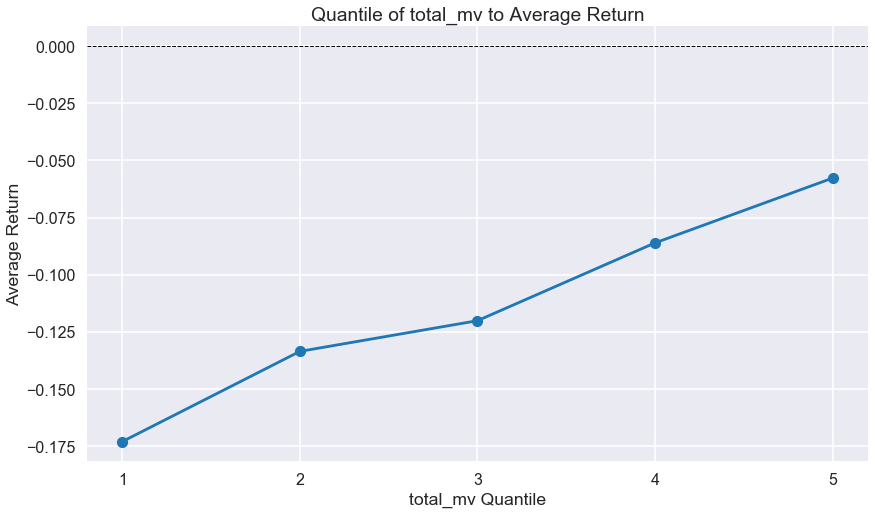

In [59]:
plot_quantile_return(df_all, 'total_mv')

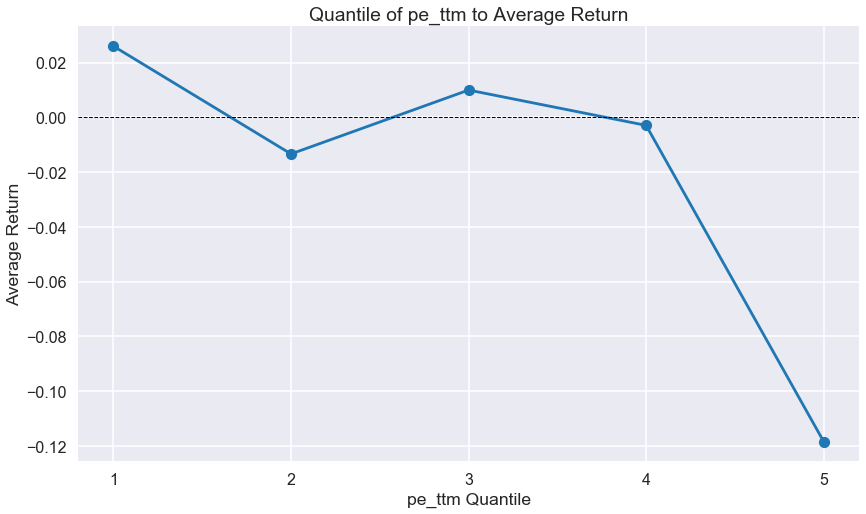

In [34]:
plot_quantile_return(df_all, 'pe_ttm')

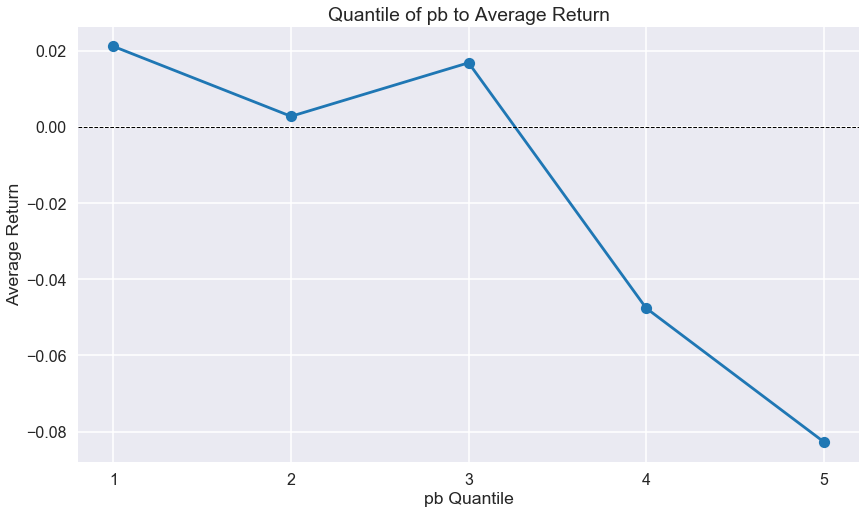

In [35]:
plot_quantile_return(df_all, 'pb')